In [1]:
import random
import matplotlib

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm
from collections import Counter
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import clear_output

In [2]:
def print_stats(day):
    return "day:", day , "population:", len(population), "infected:", get_status(), "hospitalised:", len(hospitalised), "probability:", get_status()/len(population)

In [3]:
def gen_rand_coordinates(n):
    x = np.random.randint(low=0, high=2*n, size=n)
    y = np.random.randint(low=0, high=2*n, size=n)
    
    coordinates = [(i, j) for i, j in zip(x, y)]
    
    return list(set(coordinates)), list(range(len(set(coordinates))))

In [4]:
def random_walk(current_position, person):
    path = []
    edges = []
    path.append(deepcopy(current_position))
    
    percentage = 0 #int(len(hospitalised)/2000)
    
    if person['age']>15 and person['age']<60:
        m = 50
        m_ = int(m/10)
        m = m - (m_*percentage)
        n = np.random.randint(0, m)
        
    else:        
        m = 40
        m_ = int(m/10)
        m = m - (m_*percentage)
        n = np.random.randint(0, m)
        
    for i in range(n):
        person_neighbours = neighbours[current_position]
        if len(person_neighbours) > 0:
            next_position = np.random.choice(person_neighbours)
            path.append(next_position)
            edges.append((current_position, next_position))
            current_position = deepcopy(next_position)
    return path, edges

In [5]:
def random_sample(data, n):
    idx = np.random.randint(low=0, high=len(data), size=n)
    return [data[i] for i in idx], idx

In [6]:
def get_status(effected=True):
    return Counter([p['state']=='infected' for p in population.values()])[effected]

In [7]:
def get_p_at(effected=True):
    return [p['at'] for p in population.values() if p['state']=='infected']

In [8]:
def effect_person(person):
    person['state'] = 'infected'
    person['incubation_period'] = np.random.randint(low=2, high=12)

In [9]:
def plot_plot(rw_normal_edges=None, rw_effected_edges=None, clear=False, iter_=0):
    clear_output(wait=clear)
    
    pop = [p['at'] for i, p in population.items()]
    eff = get_p_at()

    plt.figure(0, figsize=(25, 25))
    
    nx.draw_networkx_nodes(G, pos,
                           nodelist=pop,
                           node_color='blue', node_size=5)

    nx.draw_networkx_nodes(G, pos,
                           nodelist=eff,
                           node_color='r', node_size=50)

    nx.draw_networkx_edges(G, pos,
                           edgelist=edges,
                           width=0.3,alpha=0.3,edge_color='b')

    if rw_normal_edges is not None:
        nx.draw_networkx_edges(G,pos,
                               edgelist=rw_normal_edges,
                               width=0.5,alpha=0.3,edge_color='y')

        nx.draw_networkx_edges(G,pos,
                               edgelist=rw_effected_edges,
                               width=2,alpha=0.3,edge_color='red')

    nx.draw_networkx(G, pos, node_size=1, with_labels=False)
    s = "Day: "+str(iter_)+" | Population: " + str(len(population)) + " | Infected: " + str(get_status()) + " | Hospitalised: " + str(len(hospitalised)) + " | Infection Probability: " + str(round(get_status()/len(population), 2)) + " | Cured: " + str(len(cured)) + " | Dead: " + str(len(dead))
    plt.title(s, fontsize=20)
    plt.savefig("image"+str(iter_)+".png", format="PNG")
    plt.show()

In [10]:
def is_dead(p):
    for i in p['comorbidities']:
        if i in comorbidities_deceased:
            k = comorbidities_deceased[i]
            ps = np.array([100-k, k])/100
            if np.random.choice([False, True], p=ps):
                return True

    n = n_comorbidities_deceased[p['n_comorbidities']]
    if np.random.choice([False, True], p=[1-n, n]):
        return True

    age = p['age']
    
    if age <= 40: #age >= 10 and age 
        prob = 0.2
    elif age >= 40 and age <= 49:
        prob = 0.4
    elif age >= 50 and age <= 59:
        prob = 1.3
    elif age >= 60 and age <= 69:
        prob = 3.6
    elif age >= 70 and age <= 79:
        prob = 8.0
    elif age >= 80:
        prob = 14.8

    prob_ = np.array([100-prob, prob])

    if np.random.choice([False, True], p=prob_/100):
        return True
    return False

In [11]:
n_days = 100

In [12]:
n_nodes = 1000
connectivity = 5
n_population = n_nodes * 2
n_effected_people = 2 #int(n_population/100)

contamination_confidence = 100

In [13]:
coordinates, coordinates_idx = gen_rand_coordinates(n_nodes)

In [14]:
_, p_coord = random_sample(coordinates, n_population)

In [15]:
# p_ages = np.random.randint(low=2, high=80, size=n_population)

In [16]:
### Germany

# 0-14 years: 12.83% (male 5,299,798 /female 5,024,184)
# 15-24 years: 9.98% (male 4,092,901 /female 3,933,997)
# 25-54 years: 39.87% (male 16,181,931 /female 15,896,528)
# 55-64 years: 14.96% (male 5,989,111 /female 6,047,449)
# 65 years and over: 22.36% (male 7,930,590 /female 10,061,248) (2018 est.)

In [17]:
# Diseases N %
# schemic heart disease 145 30.1
# Atrial Fibrillation 106 22.0
# Stroke 54 11.2
# Hypertension 355 73.8
# Diabetes 163 33.9
# Dementia 57 11.9
# COPD 66 13.7
# Active cancer in the past 5 years 94 19.5
# Chronic liver disease 18 3.7
# Chronic renal failure 97 20.2

In [18]:
comorbidities_deceased = {'Congestive Heart Failure': 30.1, 'Stroke': 11.2, 'Hypertension': 73.8,
                         'Diabetes Mellitus': 33.9, 'Dementia': 11.9, 'Respiratory Disease': 13.7}

In [19]:
#  0 comorbidities 6 1.2
#  1 comorbidity 113 23.5
#  2 comorbidities 128 26.6
#  3 comorbidities and over 234 48.6

In [20]:
n_comorbidities_deceased = np.array([1.3, 23.5, 26.6, 48.6])

In [21]:
n_comorbidities_deceased = n_comorbidities_deceased/n_comorbidities_deceased.sum()

In [22]:
age_dist = np.array([12.83, 9.98, 39.87, 14.96, 22.36])

In [23]:
p_ages = []
p_n_comorbidities = []

for i in range(n_population):
    age_dist_sampled = np.random.choice([0, 1, 2, 3, 4], p=age_dist/100)
    
    if age_dist_sampled == 0:
        age_sampled = np.random.randint(low=0, high=14)
        comorbiditiy_sampled = 0 #np.random.choice([0, 1, 2, 3], p=[0.90, 0.05, 0.03, 0.02])
        
    elif age_dist_sampled == 1:
        age_sampled = np.random.randint(low=15, high=24)
        comorbiditiy_sampled = np.random.choice([0, 1, 2, 3], p=[0.80, 0.10, 0.06, 0.04])
        
    elif age_dist_sampled == 2:
        age_sampled = np.random.randint(low=25, high=54)
        comorbiditiy_sampled = np.random.choice([0, 1, 2, 3], p=[0.60, 0.20, 0.10, 0.10])
        
    elif age_dist_sampled == 3:
        age_sampled = np.random.randint(low=55, high=64)
        comorbiditiy_sampled = np.random.choice([0, 1, 2, 3], p=[0.40, 0.30, 0.15, 0.15])
        
    elif age_dist_sampled == 4:
        age_sampled = np.random.randint(low=65, high=100)
        comorbiditiy_sampled = np.random.choice([0, 1, 2, 3], p=[0.30, 0.30, 0.20, 0.20])
        
    p_ages.append(age_sampled)
    p_n_comorbidities.append(comorbiditiy_sampled)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a224edf90>]],
      dtype=object)

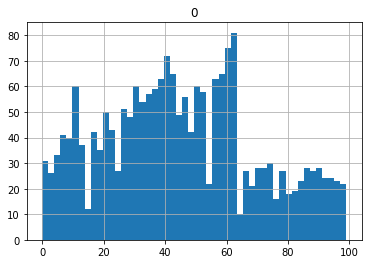

In [24]:
pd.DataFrame(p_ages).hist(bins=50)

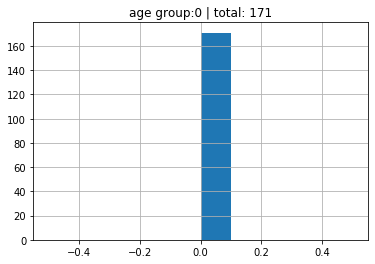

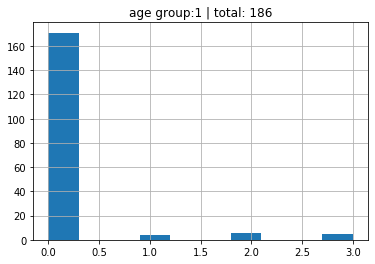

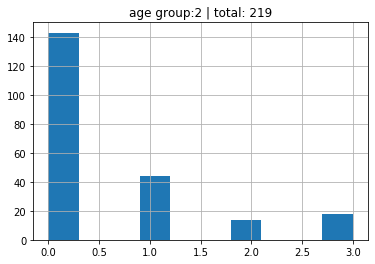

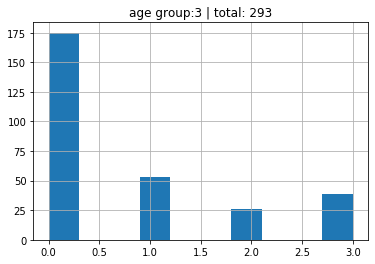

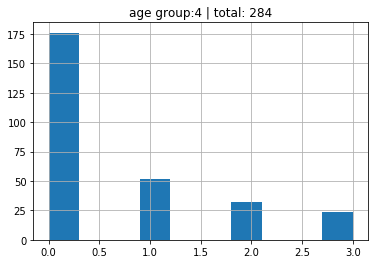

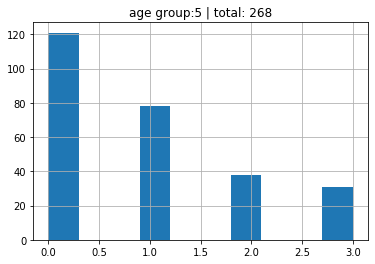

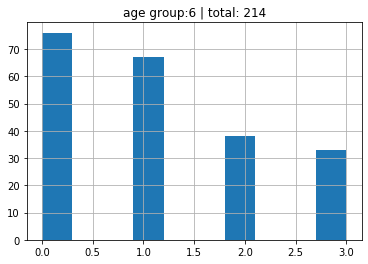

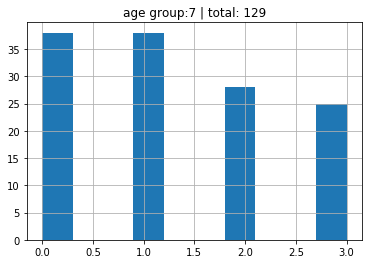

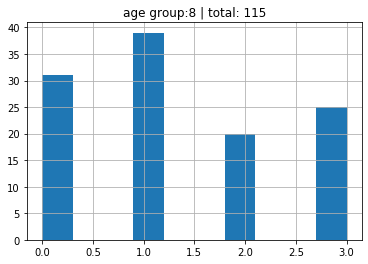

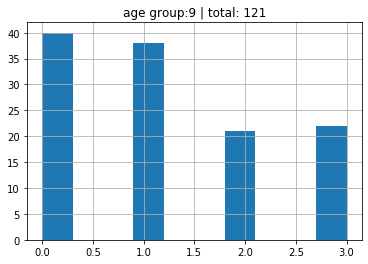

In [25]:
k = pd.DataFrame([(np.array(p_ages)/10).astype(int), p_n_comorbidities]).T

for i in range(10):
    k[k[0]==i][1].hist()
    plt.title("age group:"+str(i)+" | total: " + str(k[k[0]==i].shape[0]))
    plt.show()

In [26]:
age_comorbidities = pd.read_csv("age_comorbitidites.csv")

In [27]:
age_comorbidities.iloc[:, 1] = age_comorbidities.iloc[:, 1]/np.sum(age_comorbidities.iloc[:, 1])
age_comorbidities.iloc[:, 2] = age_comorbidities.iloc[:, 2]/np.sum(age_comorbidities.iloc[:, 2])
age_comorbidities.iloc[:, 3] = age_comorbidities.iloc[:, 3]/np.sum(age_comorbidities.iloc[:, 3])
age_comorbidities.iloc[:, 4] = age_comorbidities.iloc[:, 4]/np.sum(age_comorbidities.iloc[:, 4])

In [28]:
comorbidities = age_comorbidities.iloc[:, 0]

In [29]:
age_comorbidities.head()

,Comorbid Ailment,18-53,54-64,65-73,74-102
0,Myocardial Infarct,0.023754,0.043632,0.053722,0.057679
1,Angina/ Artery Disease,0.031112,0.070618,0.094730,0.096760
2,Congestive Heart Failure,0.011352,0.018916,0.020504,0.041738
3,Hypertension,0.283582,0.326356,0.303363,0.252485
4,Arrhythmias,0.014505,0.025725,0.037216,0.065135


In [30]:
p_comorbidities = []

for i, j in zip(p_ages, p_n_comorbidities):
    c = []
    if i < 18:
        c = []
    elif i >= 18 and i <= 53:
        c = np.random.choice(comorbidities, p=age_comorbidities.iloc[:, 1], size=j, replace=False)
    elif i >= 54 and i <= 64:
        c = np.random.choice(comorbidities, p=age_comorbidities.iloc[:, 2], size=j, replace=False)
    elif i >= 65 and i <= 73:
        c = np.random.choice(comorbidities, p=age_comorbidities.iloc[:, 3], size=j, replace=False)
    elif i >= 74:
        c = np.random.choice(comorbidities, p=age_comorbidities.iloc[:, 4], size=j, replace=False)
    p_comorbidities.append(list(c))

In [31]:
population = {i:{'at': j, 'age': k, 'state': 'free', 
                 'incubation_period':-1, 'comorbidities': m, 'n_comorbidities':l}
              for i, j, k, l, m in zip(range(n_population), p_coord, p_ages, p_n_comorbidities, p_comorbidities)}

In [32]:
effected, _ = random_sample(list(population.keys()), n_effected_people)
for i in effected:
    effect_person(population[i])
del effected

In [33]:
edges = []
c = np.array(coordinates)
while len(set(edges)) < n_nodes * connectivity:
    print(len(set(edges)))
    t, t_idx = random_sample(c, 1000)
    u, u_idx = random_sample(c, 1000)
    dist = euclidean_distances(t, u)
    for idx, i in enumerate(dist):
        a = np.argsort(i)[:2]
        edges += [(t_idx[idx], u_idx[j]) for j in a if i[j]<(n_nodes/10) and i[j] != 0]
edges = set(edges)

0
594
1039
1404
1729
1951
2193
2353
2514
2654
2767
2886
2973
3065
3144
3235
3317
3398
3490
3544
3614
3669
3717
3772
3812
3847
3883
3928
3960
4019
4055
4080
4113
4160
4198
4227
4257
4290
4317
4343
4361
4387
4409
4427
4459
4486
4500
4520
4539
4553
4572
4585
4598
4623
4648
4667
4686
4703
4719
4732
4740
4758
4779
4793
4805
4818
4826
4843
4855
4868
4880
4893
4908
4929
4939
4958
4967
4977
4991


In [34]:
neighbours = {i:[] for i in coordinates_idx}
for i, j in edges:
    neighbours[i] += [j]
    neighbours[j] += [i]

In [35]:
len(coordinates), len(population), len(edges), get_status()

(1000, 2000, 5002, 2)

In [36]:
G_dash = nx.Graph()
for p in tqdm(range(len(coordinates))):
    G_dash.add_node(p, pos=[coordinates[p][0], coordinates[p][1]])
pos = nx.get_node_attributes(G_dash, 'pos')
G = deepcopy(G_dash)

100%|██████████| 1000/1000 [00:00<00:00, 227210.40it/s]


In [37]:
hospitalised, cured, dead = {}, {}, {}

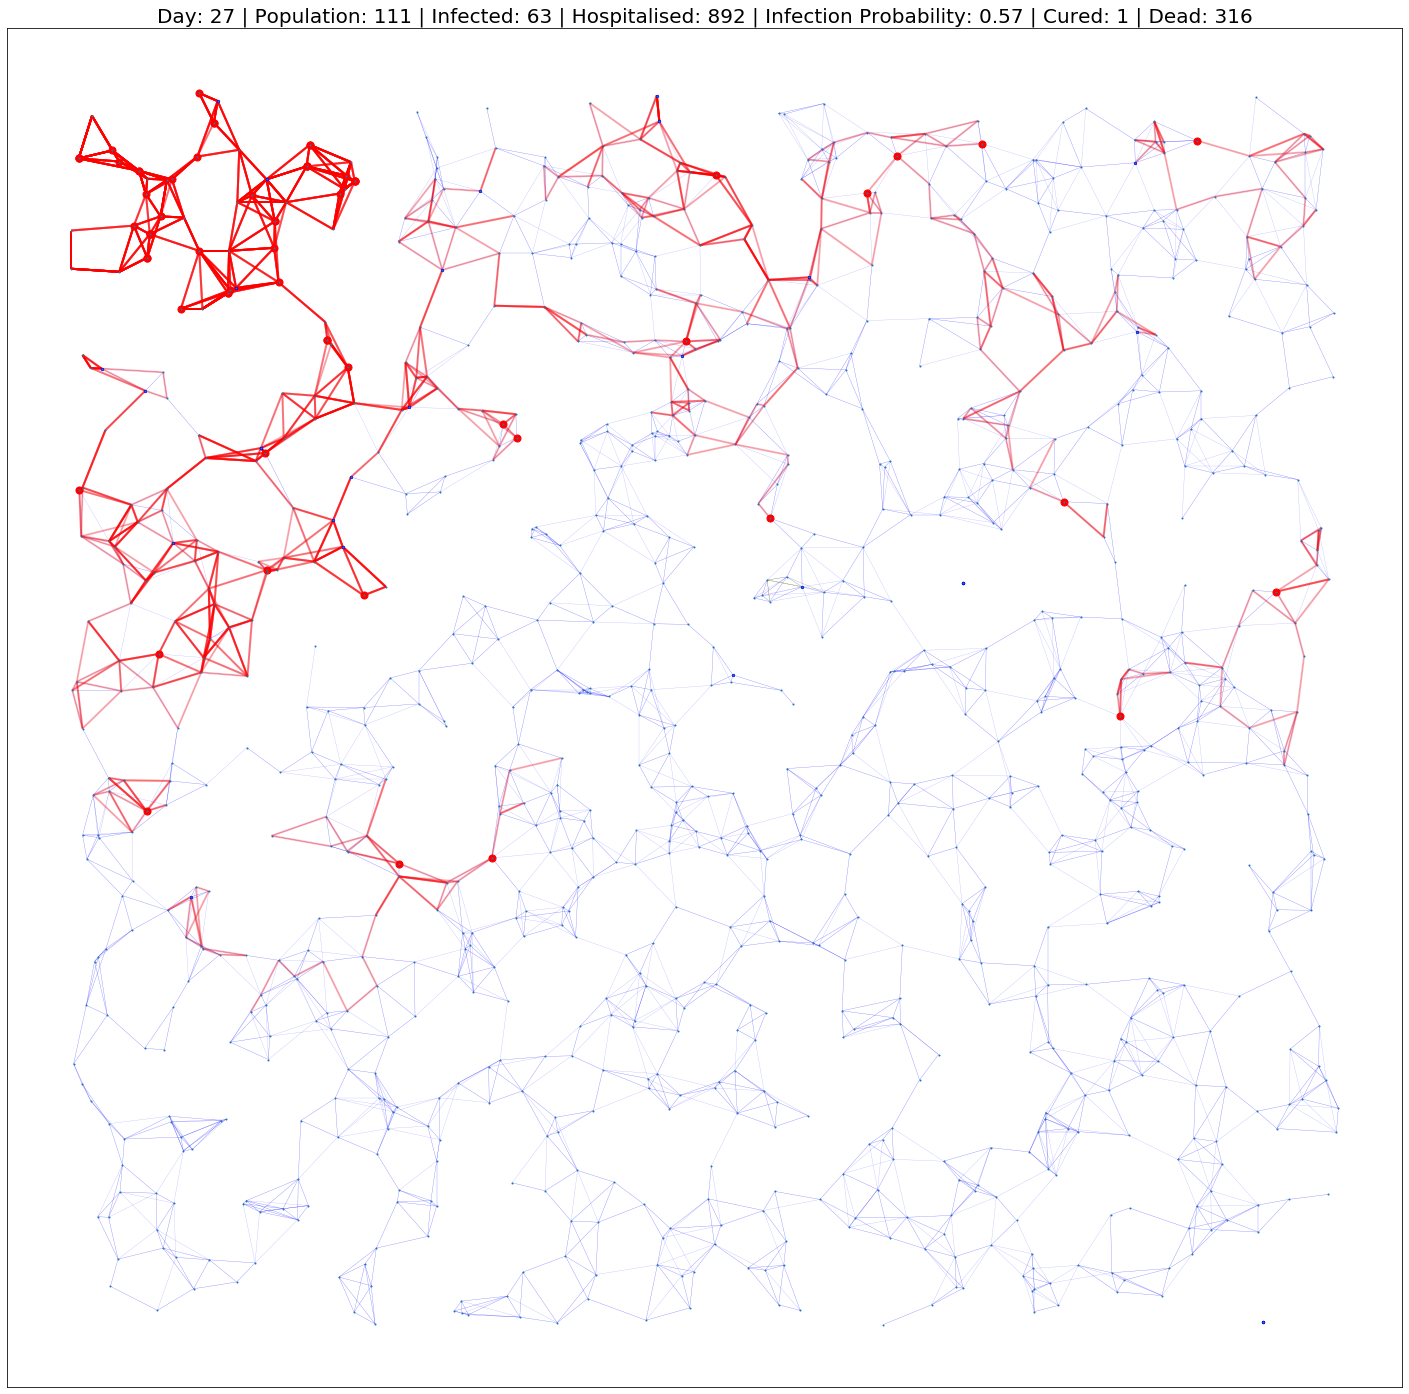

UnboundLocalError: local variable 'prob' referenced before assignment

In [38]:
for day in range(n_days):

    print_stats(day)
    
    del_pids, del_hids = [], []
    
    rw_normal = {}
    rw_effected = {}

    rw_normal_edges = []
    rw_effected_edges = []

    for pid, person in population.items():
        current_position = person['at']
        _, rw_edges = random_walk(current_position, person)

        if person['state']=='infected':
            rw_effected[pid] = rw_edges
            rw_effected_edges += rw_edges
            
            person['incubation_period'] -= 1
            
            if person['incubation_period'] == 0:
                person['end_period'] = np.random.randint(5, 15)
                person['state'] = 'hospitalised'
                hospitalised[pid] = person
                del_pids.append(pid)
        else:
            rw_normal[pid] = rw_edges
            rw_normal_edges += rw_edges
            
    for pid, person in hospitalised.items():
        person['end_period'] -= 1
        
        if person['end_period'] == 0:
            if is_dead(person):
                person['state'] = 'dead'
                dead[pid] = person
            else:
                person['state'] = 'cured'
                cured['pid'] = person
            del_hids.append(pid)
            

    contaminated_paths = Counter(rw_effected_edges)
    
    plot_plot(iter_=day, rw_effected_edges = rw_effected_edges, rw_normal_edges=rw_normal_edges)

    for pid, j in rw_normal.items():
        similar_paths = list(set(j).intersection(set(rw_effected_edges)))
        
        contamination_probability = sum([contaminated_paths[s] for s in similar_paths])

        denominator = contamination_confidence + contamination_probability
        if np.random.choice([0, 1], p=[contamination_confidence/denominator, contamination_probability/denominator]):
            effect_person(population[pid])
            
    for pid in del_pids:
        del population[pid]
        
    for pid in del_hids:
        del hospitalised[pid]

In [40]:
person

{'at': 317,
 'age': 80,
 'state': 'hospitalised',
 'incubation_period': 0,
 'comorbidities': [],
 'n_comorbidities': 0,
 'end_period': 0}